<a href="https://colab.research.google.com/github/Nina-Om/ArcGIS-MapBook-Toolbox/blob/master/2_LCRB_Aggmon_Analog_streamflow_prediction_tclw_BOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run predictive kNN model for analog based monsoon streamflow prediction in LCRB

**Title**: k-Nearest Neighbors (kNN) Analysis for Identifying Analog Years and Streamflow Prediction \
**Author**: Nina Omani \
**Date created**: 2/14/2024  \
\
**Description**: \
This notebook uses the k-Nearest Neighbors (kNN) algorithm to identify analog years based on hydroclimate condition and streamflow data. \

It standardizes hydroclimate features, performs kNN to find the 4 closest analog years, and calculates streamflow predictions. \

The script then evaluates the predictive performance using metrics such as MAE, RMSE, and MAPE, and visualizes the results. \

**Requirements:** \
The script requires the following input files: \
*   **2.WT_combined_data.csv**: Output from the **1.WT_File_gather.R** script, containing weather type data with streamflow information.
*   **BOR Intervening Flows Data 1971-2022_NFDextension v2.xlsx**: Streamflow observation data.

**Hindcast WTs:** 1981-2023 \
**Available Historic WTs:** 1970-2023 \
**Streamflow:** 1972-2022 \
**Evaluation period:** 1993-2021


Ensure these files are present and paths are correctly set. \



# Runtime setup:
To activate the R kernel in Google Colab, follow these steps:, make sure you select "R" Runtime type under "Runtime", "Change runtime type", Runtime type:R.

# **Experiments**

`ECMWF <- TRUE `  
 Determines whether the experiment uses ECMWF data (TRUE) or SMYLE data (FALSE). \


**Baseline Experiment or Default Conditions** \
`feature <- FALSE`      
Indicates whether to include antecedent streamflow and WTs predictors (FALSE for no antecedent predictors).

`AGGREGATE <- FALSE `  
Does not use aggregated WTs predictors (FALSE). Aggregated WTs predictors (JJASO, JASO, ASO, etc.). It uses monthly WTs predictors. \
```
combinations <- data.frame(
  region = c("AZ_West", "AZ_West"),
  gage = c("Glen_Hoover", "Total_Below_Parker")
)
```

**Experiment 1:** Aggregated WTs as Predictors. \
Similar to the baseline but with aggregated WTs predictors (AGGREGATE <- TRUE). \
`feature <- FALSE`      
`AGGREGATE <- TRUE `  
```
combinations <- data.frame(
  region = c("AZ_West", "AZ_West"),
  gage = c("Glen_Hoover", "Total_Below_Parker")
)
```
**Experiment 2.** Influence of initial conditions \
`feature <- streamflow`      Includes antecedent streamflow as a predictor \
`AGGREGATE <- FALSE `  Does not use aggregated WTs predictors
```
combinations <- data.frame(
  region = c("AZ_West", "AZ_West"),
  gage = c("Glen_Hoover", "Total_Below_Parker")
)
```
**Experiment 4:** Regional weather impact assessment. \
`feature <- FALSE`  Does not include antecedent predictors \
`AGGREGATE <- FALSE `  Does not use aggregated WTs predictors

First run:
```
combinations <- data.frame(
  region = c("AZ_East", "AZ_West"),
  gage = c("Glen_Hoover", "Glen_Hoover")
)
```
Second run:
```
combinations <- data.frame(
  region = c("AZ_East", "AZ_West"),
  gage = c("Total_Below_Parker", "Total_Below_Parker")
)
```



#FNN package
**get.knnx function:**
  
It is designed to find the k-nearest neighbors of a set of query points in a given dataset. \

It takes two main input matrices: data (the dataset in which to search for neighbors) and query (the points for which neighbors are found). \

This function is useful when you have a specific set of points outside your dataset for which you want to find neighbors within your dataset. \


In [89]:
#Install the packages if required
if (!requireNamespace("readr", quietly = TRUE)) install.packages("readr")
if (!requireNamespace("FNN", quietly = TRUE)) install.packages("FNN")
if (!requireNamespace("zoo", quietly = TRUE)) install.packages("zoo")
if (!requireNamespace("reshape2", quietly = TRUE)) install.packages("reshape2")
if (!requireNamespace("Metrics", quietly = TRUE)) install.packages("Metrics")
if (!requireNamespace("readxl", quietly = TRUE)) install.packages("readxl")
if (!requireNamespace("tidyr", quietly = TRUE)) install.packages("tidyr")
if (!requireNamespace("tibble", quietly = TRUE)) install.packages("tibble")
if (!requireNamespace("dplyr", quietly = TRUE)) install.packages("dplyr")
if (!requireNamespace("ggplot2", quietly = TRUE)) install.packages("ggplot2")
if (!requireNamespace("grid", quietly = TRUE)) install.packages("grid")
if (!requireNamespace("gridExtra", quietly = TRUE)) install.packages("gridExtra")
if (!requireNamespace("reticulate", quietly = TRUE)) install.packages("reticulate")
if (!requireNamespace("googledrive", quietly = TRUE)) install.packages("googledrive")

In [90]:
library(FNN)
library(readr)
library(dplyr)
library(tibble)
library(ggplot2)
library(readxl)
library(zoo)
library(reshape2)
library(tidyr)
library(Metrics)
library(grid)
library(gridExtra)
library(googledrive)
library(reticulate)

In [91]:
# Execute Python code to mount Google Drive using system
system("python3 -c 'from google.colab import drive; drive.mount(\"/content/drive\")'")

# Functions (0.Functions.R)

In [92]:
# Function definitions

standardize <- function(x) {
  (x - mean(x, na.rm = TRUE)) / sd(x, na.rm = TRUE)}

# Filter and prepare historic and forecast data for the kNN analysis.
prepare_data <- function(data, years, months, obs = TRUE) {
  # Select columns based on whether preparing observed (obs) or forecasted (for) data
  select_cols <- if (obs) c("Year", "Month", grep("_obs$|.obs$", names(data), value = TRUE)) else c("lead_date", "lead_month", "Year", "Month", grep("_for$|.for$", names(data), value = TRUE))

  prepared_data <- data %>%
    filter(Year %in% years, Month %in% months) %>%
    select(all_of(select_cols)) %>%
    na.omit() %>%
    distinct()

  prepared_data <- prepared_data %>%
    mutate(across(everything(), as.numeric))

  return(prepared_data)
}
# Conduct initial data exploration, including correlation analysis and plotting of monthly means.
perform_data_exploration <- function(data) {
  # Correlation analysis
  cor_matrix_for <- cor(data %>% select(dry.for, normal.for, monsoon.for), use = "complete.obs")
  #print(cor_matrix_for)

  cor_matrix_obs <- cor(data %>% select(dry.obs, normal.obs, monsoon.obs), use = "complete.obs")
  #print(cor_matrix_obs)

  # Plotting mean monthly values
  monthly_means <- data %>%
    group_by(Month) %>%
    summarise(
      mean_dry_obs = mean(dry.obs, na.rm = TRUE),
      mean_normal_obs = mean(normal.obs, na.rm = TRUE),
      mean_monsoon_obs = mean(monsoon.obs, na.rm = TRUE)
    ) %>%
    ungroup()

  ggplot(monthly_means, aes(x = Month)) +
    geom_line(aes(y = mean_dry_obs, color = "Dry"), size = 1) +
    geom_line(aes(y = mean_normal_obs, color = "Normal"), size = 1) +
    geom_line(aes(y = mean_monsoon_obs, color = "Monsoon"), size = 1) +
    scale_color_manual(values = c("Dry" = "red", "Normal" = "green", "Monsoon" = "blue")) +
    labs(title = "Mean Monthly Observations", x = "Month", y = "Mean Observation Value", color = "Observation Type") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
}

AntecedentMeans <- function(data, n) {
  if(n == 1) {
    return(c(NA, head(data, -1)))
  } else {
    antecedent_means <- rep(NA, length(data))
    for(i in (n+1):length(data)) {
      antecedent_means[i] <- mean(data[(i-n):(i-1)], na.rm = TRUE)
    }
    return(antecedent_means)
  }
}

#antecedent_monthly <- AntecedentMeans(monthly_data, 1)
#antecedent_mean_two_months <- AntecedentMeans(monthly_data, 2)
#antecedent_mean_three_months <- AntecedentMeans(monthly_data, 3)

# Function to perform kNN and find analogs, appending results to a dataframe (more features)
find_analogs_for_month_and_lead <- function(historic_data, forecast_data, month, lead_month, k) {

  results_df <- data.frame()

  historic_filtered <- na.omit(historic_data[historic_data$Month == month, ])

  forecast_filtered <- na.omit(
    forecast_data[forecast_data$Month == month & forecast_data$lead_month == lead_month,])
  forecast_filtered <- dplyr::select(forecast_filtered, -c(lead_date, lead_month))

  obs_cols_historic <- grep("_obs$", names(historic_filtered), value = TRUE)
  if(!all(sapply(historic_filtered[, obs_cols_historic], is.numeric))) {
    stop("Non-numeric data found in historic_filtered.")
  }

  for_cols_forecast <- grep("_for$", names(forecast_filtered), value = TRUE)
  if(!all(sapply(forecast_filtered[, for_cols_forecast], is.numeric))) {
    stop("Non-numeric data found in forecast_filtered.")
  }

  historic_matrix <- historic_filtered %>%
    select(contains("_obs")) %>%
    data.matrix()

  forecast_matrix <- forecast_filtered %>%
    select(contains("_for")) %>%
    data.matrix()

  if (ncol(historic_matrix) != ncol(forecast_matrix)) {
    stop("Number of features in historic and forecast data does not match.")}

  # Perform kNN
  knn_result <- get.knnx(historic_matrix, forecast_matrix, k = k)

  for (i in seq_len(nrow(forecast_matrix))) {
    # Calculate distances and weights for the current forecast's analogs
    analog_distances <- knn_result$nn.dist[i, ]
    analog_weights <- 1 / (analog_distances + 1e-5)
    weights_normalized <- analog_weights / sum(analog_weights) # Normalize the weights

    for (j in 1:k) {
      analog_year <- historic_filtered$Year[knn_result$nn.index[i, j]]
      results_df <- rbind(results_df, data.frame(
        ForecastYear = forecast_filtered$Year[i],
        Month = month,
        LeadMonth = lead_month,
        AnalogYear = analog_year,
        Distance = analog_distances[j],
        Weight = weights_normalized[j],
        Rank = j))
    }
  }
  return(results_df)
}


# Function to perform kNN and find analogs, appending results to a dataframe (more features) for each month in stream flow data
find_analogs_for_season_and_lead <- function(historic_data, forecast_data, month, season,lead_month, k) {
  # historic_data$Month   season="JJASO";   lead_month = 4;   k=4; month=6
  results_df <- data.frame()

  historic_filtered <- na.omit(historic_data[historic_data$Month == month, ])

  forecast_filtered <- na.omit(
    forecast_data[forecast_data$Month %in% month & forecast_data$lead_month == lead_month,])

  forecast_filtered <- dplyr::select(forecast_filtered, -c(lead_date, lead_month))

  obs_cols_historic <- grep("_obs$", names(historic_filtered), value = TRUE)
  if(!all(sapply(historic_filtered[, obs_cols_historic], is.numeric))) {
    stop("Non-numeric data found in historic_filtered.")
  }

  for_cols_forecast <- grep("_for$", names(forecast_filtered), value = TRUE)
  if(!all(sapply(forecast_filtered[, for_cols_forecast], is.numeric))) {
    stop("Non-numeric data found in forecast_filtered.")
  }

  historic_matrix <- historic_filtered %>%
    select(contains("sd")) %>%
    select(-c("sd_dry_obs","sd_normal_obs","sd_monsoon_obs")) %>% # keep only aggregated data
    data.matrix()

  forecast_matrix <- forecast_filtered %>%
    select(contains("sd")) %>%
    select(-c("sd_dry_for","sd_normal_for","sd_monsoon_for")) %>%  # keep only aggregated data
    data.matrix()

  if (ncol(historic_matrix) != ncol(forecast_matrix)) {
    stop("Number of features in historic and forecast data does not match.")}

  # Perform kNN
  knn_result <- get.knnx(historic_matrix, forecast_matrix, k = k)

  # Loop through each forecast to extract and store results
  for (i in seq_len(nrow(forecast_matrix))) {
    # Calculate distances and weights for the current forecast's analogs
    analog_distances <- knn_result$nn.dist[i, ]
    analog_weights <- 1 / (analog_distances + 1e-5)
    weights_normalized <- analog_weights / sum(analog_weights) # Normalize the weights

    for (j in 1:k) {
      analog_year <- historic_filtered$Year[knn_result$nn.index[i, j]]
      results_df <- rbind(results_df, data.frame(
        ForecastYear = forecast_filtered$Year[i],
        Month = month,
        Season=season,
        LeadMonth = lead_month,
        AnalogYear = analog_year,
        Distance = analog_distances[j],
        Weight = weights_normalized[j],
        Rank = j))
    }
  }
  return(results_df)
}

#The function mape calculates the Mean Absolute Percentage Error (MAPE)
mape <- function(actual, predicted) {
  mean(abs((actual - predicted) / actual), na.rm = TRUE) * 100
}

# Step 0: Define WT Data Period

In [93]:
  forecast_years <- 1981:2023  #1981:2023 #1993:2021
  historic_years <-  1985:2023   #1970:2023 increases forecast skill #1982:2018 decreases forecast skill

# Step 1: Select the model SMYLE or ECMWF and upload reanalysis/hindcast WTs and streamflow data

**Select a model and create output folders: ECMWF or SMYLE**

In [94]:
ECMWF <- T    #If FALSE, it uploades SMYLE data

if (ECMWF) {
  model_dir <- "ECMWF"
  if (!dir.exists(model_dir)) {
    dir.create(model_dir)
  }
  system("gdown '1GMrN8ynFg0hDkf8MYmmrHauehzQkCmRa' -O /content/ECMWF/2.WT_combined_data.csv")
 } else {
  model_dir <- "SMYLE"

  if (!dir.exists(model_dir)) {
    dir.create(model_dir)
  }
  system("gdown '1mcSZZ2UCyRYjrse-P_cOGX920aj6nXDY' -O /content/SMYLE/2.WT_combined_data.csv")
}

**Download input data for the selected model**

### Weather Type data

In [95]:
# List files in your Google Drive
list.files('/content/')

[1] "5_combined_forecast_variables.csv"                   
 [2] "BORInterveningFlowsData1971-2022_NFDextensionv2.xlsx"
 [3] "ECMWF"                                               
 [4] "ECMWF_tclw_only123"                                  
 [5] "ECMWF_tclw_wt123"                                    
 [6] "ERA_q_regional.csv"                                  
 [7] "ERA_tclw_regional.csv"                               
 [8] "ERA_tcwv_regional.csv"                               
 [9] "merged_q_tclw_tcwv.csv"                              
[10] "merged_q.csv"                                        
[11] "merged_tclw.csv"                                     
[12] "sample_data"                                         
[13] "SMYLE"

In [96]:
weather_data <- read.csv(paste0("/content/", model_dir,'/', '2.WT_combined_data.csv'))
print(head(weather_data))

  YYYYMM dry.obs normal.obs monsoon.obs Year Month  region lead_date dry.for
1 197006      26          4           0 1970     6 AZ_East        NA      NA
2 197007       1         19          11 1970     7 AZ_East        NA      NA
3 197008       0         13          18 1970     8 AZ_East        NA      NA
4 197009      17         12           1 1970     9 AZ_East        NA      NA
5 197010      28          3           0 1970    10 AZ_East        NA      NA
6 197106      30          0           0 1971     6 AZ_East        NA      NA
  normal.for monsoon.for lead_month
1         NA          NA         NA
2         NA          NA         NA
3         NA          NA         NA
4         NA          NA         NA
5         NA          NA         NA
6         NA          NA         NA


**Download streamflow data from GitHub**

In [97]:
system("gdown 'https://drive.google.com/uc?id=1jvLtMe7mWoG6KO9fm5tmeDeH3wJxTvY_' -O /content/BORInterveningFlowsData1971-2022_NFDextensionv2.xlsx")

In [98]:
streamflow_data_obs <- read_excel("/content/BORInterveningFlowsData1971-2022_NFDextensionv2.xlsx", sheet = "Summary Data")
print(head(streamflow_data_obs))

# A tibble: 6 × 7
  Date                Month  Year Glen_Hoover Parker_Imperial Imperial_Mex
  <dttm>              <dbl> <dbl>       <dbl>           <dbl>        <dbl>
1 1971-01-31 00:00:00     1  1971       96442          -13020           NA
2 1971-02-28 00:00:00     2  1971      -16241          -48473           NA
3 1971-03-31 00:00:00     3  1971        5506          -60375           NA
4 1971-04-30 00:00:00     4  1971      -25691           -7702           NA
5 1971-05-31 00:00:00     5  1971       49182          -27342           NA
6 1971-06-30 00:00:00     6  1971       21035          -46618           NA
# ℹ 1 more variable: Total_Below_Parker <dbl>


# Upload ECMWF forecasted and ERA5.1 reanalysis monthly tclw data

In [99]:
system("gdown 'https://drive.google.com/uc?id=10g9FyL6ongiESzuADnRrVi4WwFea-GZi' -O /content/5_combined_forecast_variables.csv") #output of PRISM_ECMWF_Regression_analysis_BOR.ipynb

In [100]:
forecast_data <- read_csv("/content/5_combined_forecast_variables.csv", show_col_types = FALSE)
forecast_data <- rename(forecast_data, lead_month = init_Month)
forecast_data$lead_month <- as.numeric(forecast_data$lead_month)
forecast_data <- rename(forecast_data, region = Region)

In [101]:
# Download the datasets
system("gdown 'https://drive.google.com/uc?id=1keSg1hFPEVQxWyqS4ONEDNs-aaIlGFte' -O /content/ERA_tclw_regional.csv")  # tclw
system("gdown 'https://drive.google.com/uc?id=1-DqN4uIILKEmZ0jk7jSIg4LLeZ-vhO5o' -O /content/ERA_q_regional.csv")    # q
system("gdown 'https://drive.google.com/uc?id=1opBJp6hieUF9vvxfpSnSFZqMp1LXjUM0' -O /content/ERA_tcwv_regional.csv")  # tcwv


In [102]:

era_data <- read_csv("/content/ERA_tclw_regional.csv", show_col_types = FALSE)
era_data <- rename(era_data, region = Region)   # Merge the datasets
var = "tclw"  # tcwv, tclw
merged_obs <- merge(weather_data, era_data[, c("Year", "Month", "region", "tclw")],
                     by = c("Year", "Month", "region"),
                     all.x = TRUE)

# Convert necessary columns to numeric
merged_obs$Month <- as.numeric(merged_obs$Month)
merged_obs$lead_month <- as.numeric(merged_obs$lead_month)
merged_obs$Year <- as.numeric(merged_obs$Year)
merged_obs <- rename(merged_obs, tclw_obs = tclw)

merged_for <- merge(merged_obs, forecast_data[, c("Year", "Month", "region", "lead_month", "tclw")],
                              by = c("Year", "Month", "region", "lead_month"),
                              all.x = TRUE)
merged_for <- rename(merged_for, tclw_for = tclw)

print(head(merged_for))
write.csv(as.data.frame(merged_for), file=paste0("/content/","merged_tclw.csv"))


  Year Month  region lead_month YYYYMM dry.obs normal.obs monsoon.obs lead_date
1 1970     6 AZ_East         NA 197006      26          4           0        NA
2 1970     6 AZ_West         NA 197006      20         10           0        NA
3 1970     7 AZ_East         NA 197007       1         19          11        NA
4 1970     7 AZ_West         NA 197007       2         19          10        NA
5 1970     8 AZ_East         NA 197008       0         13          18        NA
6 1970     8 AZ_West         NA 197008       0         13          18        NA
  dry.for normal.for monsoon.for    tclw_obs tclw_for
1      NA         NA          NA 0.003445794       NA
2      NA         NA          NA 0.002162012       NA
3      NA         NA          NA 0.019265396       NA
4      NA         NA          NA 0.009515254       NA
5      NA         NA          NA 0.023223509       NA
6      NA         NA          NA 0.019226136       NA


**Select the anecedent variables as a predictors** \
Currently, the best scenario is antecedent streamflow as predictor

In [103]:
# Select the feature to be considered as antecedents predictor

#Features list:
#"climate_features"       adding antecedent WTs and tclw (default condition to use monthly WTs),
#"streamflow_features"    adding antecedent streamflow and tclw (default condition to use monthly WTs),
#"all_features"           adding both antecedent WTs and streamflow and tclw (default condition to use monthly WTs),
#FALSE                    No antecedent feature, default condition to use monthly WTs

feature <- "streamflow_features"


**Select region of interest to pull atmospheric variables** \
Currenly, the best scenario is AZ_West

In [104]:

combinations <- data.frame(
  region = c("AZ_West", "AZ_West"),  #region : "AZ_East", "AZ_West"
  gage = c("Glen_Hoover", "Total_Below_Parker") #gages: Total_Below_Parker, Glen_Hoover
)


# Step 2: Data preparation for kNN analysis

Target year period and search pool length should be defined in Step1, below function. Currently, they are: \
  forecast_years : 1981:2023  \
  historic_years :  1970:2023  \

**2.LCRB_singlemonth_Analog_streamflow_prediction.R**

To exclude WT predictore, comment out:

sd_dry_for = ifelse(is.na(dry.for), NA, standardize(dry.for)), \
sd_normal_for = ifelse(is.na(normal.for), NA, standardize(normal.for)), \
sd_monsoon_for = ifelse(is.na(monsoon.for), NA, standardize(monsoon.for)), \
sd_dry_obs = ifelse(is.na(dry.obs), NA, standardize(dry.obs)), \
sd_normal_obs = ifelse(is.na(normal.obs), NA, standardize(normal.obs)), \
sd_monsoon_obs = ifelse(is.na(monsoon.obs), NA, standardize(monsoon.obs)), \
Standardize new tclw columns, assuming they might also have NA values

In [105]:
perform_analog_analysis_singlemonth <- function(weather_data, region, gage, forecast_years, historic_years) {
# Step 0 : preprocess WT data with streamflow information #################################################################
detrend <- FALSE  # Set to FALSE if you do not want to detrend

# Step 0: Preprocess WT data with streamflow informations
weather_data_reg = weather_data[weather_data['region'] == region,]
weather_data_reg = as.data.frame(weather_data_reg)

standardize_if_exists <- function(df, col_name) {
  if (col_name %in% names(df)) {
    return(ifelse(is.na(df[[col_name]]), NA, standardize(df[[col_name]])))
  } else {
    return(NULL)  # Return NULL if the column doesn't exist
  }
}

# Standardize existing weather type columns and new tclw, q, tcwv columns
weather_data_reg <- weather_data_reg %>%
  mutate(
    Month = as.numeric(Month),
    lead_month = as.numeric(lead_month),
    Year = as.numeric(Year),
    ## Standardize existing weather type columns
    sd_dry_for = ifelse(is.na(dry.for), NA, standardize(dry.for)),
    sd_normal_for = ifelse(is.na(normal.for), NA, standardize(normal.for)),
    sd_monsoon_for = ifelse(is.na(monsoon.for), NA, standardize(monsoon.for)),
    sd_dry_obs = ifelse(is.na(dry.obs), NA, standardize(dry.obs)),
    sd_normal_obs = ifelse(is.na(normal.obs), NA, standardize(normal.obs)),
    sd_monsoon_obs = ifelse(is.na(monsoon.obs), NA, standardize(monsoon.obs)),
    #Standardize new tclw columns, assuming they might also have NA values
    sd_tclw_obs = standardize_if_exists(., "tclw_obs"),
    sd_tclw_for = standardize_if_exists(., "tclw_for"),
    #sd_q_obs = standardize_if_exists(., "q_obs"),
    #sd_q_for = standardize_if_exists(., "q_for"),
    #sd_tcwv_obs = standardize_if_exists(., "tcwv_obs"),
    #sd_tcwv_for = standardize_if_exists(., "tcwv_for")
  )

# Remove any NULL columns that were added due to non-existent variables
weather_data_reg <- weather_data_reg %>%
  select_if(~ !is.null(.))


  # Load streamflow data
  #streamflow_data <- read_excel("/glade/work/nomani/LCB_Moonsoon_Forecast/Analog_prediction_Rcodes/obs/BOR Intervening Flows Data 1971-2022_NFDextension v2.xlsx", sheet = "Summary Data")
  streamflow_data <- streamflow_data_obs
  new_names <- c("Glen_Hoover", "Parker_Imperial", "Imperial_Mex", "Total_Below_Parker")

  streamflow_data_long <- streamflow_data %>%
    pivot_longer(
      cols = new_names,
      names_to = "Gage",
      values_to = "Observation"
    )

  streamflow_data_long_gage <- streamflow_data_long[streamflow_data_long$Gage %in% gage,]

  streamflow_features <- streamflow_data_long_gage %>%
    group_by(Gage) %>%
    mutate(
      #ant_sd_flow_mean_1_obs = standardize(AntecedentMeans(Observation, 1)),
      #ant_sd_flow_mean_2_obs = standardize(AntecedentMeans(Observation, 2)),
      ant_sd_flow_mean_3_obs = standardize(AntecedentMeans(Observation, 3)),
      #ant_sd_flow_mean_1_for = standardize(AntecedentMeans(Observation, 1)),
      #ant_sd_flow_mean_2_for = standardize(AntecedentMeans(Observation, 2)),
      ant_sd_flow_mean_3_for = standardize(AntecedentMeans(Observation, 3))
    ) %>%
    ungroup()

# Add antecedents WT here:
  conditions <- c("sd_dry", "sd_normal", "sd_monsoon")
  suffixes <- c("for", "obs")
  weather_data_reg_features <- weather_data_reg

  for(condition in conditions) {
    for(suffix in suffixes) {
      for(n in 1:3) {
        column_name <- paste("ant", condition, n, "mean_m", suffix, sep = "_")
        original_column_name <- paste(condition, suffix, sep = "_")

        # Apply the AntecedentMeans function to each condition and suffix combination
        if (original_column_name %in% names(weather_data_reg_features)) {
          weather_data_reg_features[[column_name]] <- AntecedentMeans(weather_data_reg_features[[original_column_name]], n)
        }
      }
    }
  }

  all_features <- as.data.frame(weather_data_reg_features %>%   #antecedent WTs + antecedent streamflow + tclw
                                            left_join(streamflow_features,
                                                      by = c("Year", "Month")))
  streamflow_features_join <- as.data.frame(weather_data_reg %>%  #antededent streamflow + tclw
                                  left_join(streamflow_features,
                                            by = c("Year", "Month")))

  if (feature == "climate_features") {
    features <- weather_data_reg_features
    write.csv(features, file.path("/content/",model_dir, "4.Climate_Features.csv"))
  } else if (feature == "all_features") {
    features <- all_features
    write.csv(features, file.path("/content/",model_dir, "4.All_Features.csv"))
  } else if (feature == "streamflow_features") {
    features <- streamflow_features_join
    write.csv(features, file.path("/content/",model_dir, "4.Streamflow_Features.csv"))
  } else {  # Default condition to use original weather_data_reg
    features <- weather_data_reg
    write.csv(features, file.path("/content/",model_dir, "4.Original_Features.csv"))
  }

    # Data exploration: Correlation analysis and plotting monthly means
  perform_data_exploration(features)

  # Define forecast and historic year ranges
  #forecast_years <- 1981:2023  #1981:2023 #1993:2021
  #historic_years <-  1982:2023   #1970:2023 increases forecast skill #1982:2018 decreases forecast skill
  unique_months <- c(6, 7, 8, 9, 10)

  # Filter and prepare historic and forecast WTs data for kNN
  historic_data <- prepare_data(features, historic_years, unique_months, obs = TRUE)
  forecast_data <- prepare_data(features, forecast_years, unique_months, obs = FALSE)

#Step 2: kNN Analysis: Find 4 closest analog years ################################
  target_months <- as.numeric(unique(forecast_data$Month))
  target_lead_months <- as.numeric(unique(forecast_data$lead_month))

  Analog_years <- data.frame()

  for (month in target_months) {
    for (lead_month in target_lead_months) {
      # Append the results from each function call to the main results dataframe
      # month=7; lead_month=5
      Analog_years <- rbind(Analog_years, find_analogs_for_month_and_lead(historic_data,
                                                                            forecast_data,
                                                                            month,
                                                                            lead_month,
                                                                            k=4))
    }
  }

  analog_year <- Analog_years %>%
    mutate(Year = as.numeric(ForecastYear),
           Month = as.numeric(Month),
           Region = region)
  write.csv(as.data.frame(analog_year), file=paste0("/content/",model_dir,"/","5.Analog_years_", region, ".csv"))
#Step 3: Lookup Streamflow data to find analog streamflow for the selected gage ###############################

  streamflow_data_long_gage <- streamflow_data_long[streamflow_data_long$Gage %in% gage,]
  streamflow_with_analog <- as.data.frame(streamflow_data_long_gage %>%
                                            rename(ForecastYear = Year) %>%
                                            left_join(analog_year, by = c("ForecastYear" = "Year", "Month")) %>%
                                            filter(!is.na(AnalogYear)))

  streamflow_with_analog$ID <- rownames(streamflow_with_analog)
  #streamflow_with_analog$AnalogObservation <- NA
  write.csv(as.data.frame(streamflow_with_analog), file=paste0("/content/",model_dir,"/","6.Streamflow_with_analog_",region,"_", gage,".csv"))
  return(streamflow_with_analog)
}

**Determine if including the aggregated months (seasonal) WTs as predictor** \
Currently, the best scenario is single monthly WTs predictor

In [106]:
AGGREGATE <- F
if (AGGREGATE) {
  perform_analog_analysis <- perform_analog_analysis_aggregated
} else {
  perform_analog_analysis <- perform_analog_analysis_singlemonth
}

# Step 3: kNN Analysis: Find 4 closest analog years

In [107]:
# Initialize an empty dataframe to store combined results
combined_results <- data.frame()

# Iterate over each combination and combine results
for(i in 1:nrow(combinations)) {

  current_region <- combinations$region[i]
  current_gage <- combinations$gage[i]

  # Perform the analog analysis
  current_results <- perform_analog_analysis(merged_for, current_region, current_gage, forecast_years, historic_years)

  # Combine the results using bind_rows
  combined_results <- bind_rows(combined_results, current_results)
}

combined_results$AnalogObservation <- NA

# Loop through each row of combined_results to fill in Analog Observation
for (j in 1:nrow(combined_results)) {
  current_analog_year <- combined_results$AnalogYear[j]
  current_month <- combined_results$Month[j]
  current_region <- combined_results$Region[j]
  current_gage <- combined_results$Gage[j]

  # Find the matching Observation based on AnalogYear, Month, Region, and Gage
  matching_observation_index <- which(combined_results$ForecastYear == current_analog_year &
                                      combined_results$Month == current_month &
                                      combined_results$Region == current_region &
                                      combined_results$Gage == current_gage)

  # If a matching observation is found, update the AnalogObservation column
  if (length(matching_observation_index) > 0) {
    combined_results$AnalogObservation[j] <- combined_results$Observation[matching_observation_index[1]]
  }
}

# Save the combined results to a CSV file
write.csv(combined_results, file.path("/content/", model_dir, "7.streamflow_with_analog_All_combinations.csv"))



# **Step 4: Evaluation Metrics: Calculate and print metrics for analog and reference evaluations (mean monthly and mean annual)**
(3.Validation_metrics.R)

In [108]:
# Choose to only export result of the best analog
Best_Analog <- FALSE

In [109]:
# Selet the evaluation period
# Currently, the best scenario is 1993-2023 (we dropped the 1972-1992)
year_start_metrics <- 1993
year_end_metrics <- 2021
plot_dir <- paste0("/content/",model_dir,"/plot_output/")

if (!dir.exists(plot_dir)) {
  dir.create(plot_dir)
}

In [110]:
# Load the analog years and forecasted streamflow along with historical streamflow, generated in the previous steps.
streamflow_with_analog <- read_csv(paste0("/content/",model_dir,"/", "7.streamflow_with_analog_All_combinations.csv"), show_col_types = FALSE)
if (Best_Analog == TRUE){
streamflow_with_analog <- streamflow_with_analog[streamflow_with_analog$Rank == 1,]
}
gages <- unique(streamflow_with_analog$Gage)
print(gages)


New names:
• `` -> `...1`


[1] "Glen_Hoover"        "Total_Below_Parker"


In [111]:
# Calculate Weighted Average Analog Streamflow
streamflow_with_analog_WA <- streamflow_with_analog %>%
  group_by(Gage, Region, ForecastYear, Month, LeadMonth) %>%
  mutate(Weighted_Avg_AnalogStreamflow = sum(AnalogObservation * Weight, na.rm = TRUE) / sum(Weight, na.rm = TRUE)) %>%
  ungroup() %>%
  filter(!is.na(Weighted_Avg_AnalogStreamflow))


**Calculate Reference Moving Average and Evaluation Metrics**

In [112]:

streamflow_data <- streamflow_data_obs

new_names <- c("Glen_Hoover", "Parker_Imperial", "Imperial_Mex", "Total_Below_Parker")

streamflow_data_long <- streamflow_data %>%
  pivot_longer(
    cols = all_of(new_names),
    names_to = "Gage",
    values_to = "Observation"
  )

streamflow_data_long <- streamflow_data_long %>%
  filter(Gage %in% gages)

# Calculate previous 5-year moving average
streamflow_Reference <- streamflow_data_long %>%
  arrange(Gage, Year, Month) %>%
  group_by(Gage, Month) %>%
  mutate(
    Moving_Average = rollapply(Observation, width = 5, FUN = mean, by.column = TRUE, align = "right", fill = NA),
    Prev_5Yr_Moving_Avg = lag(Moving_Average)
  ) %>%
  filter(!is.na(Prev_5Yr_Moving_Avg) & !is.na(Observation)) %>%
  ungroup()

# Evaluate data for the specified forecast years
eval_data <- streamflow_with_analog_WA %>%
  filter(ForecastYear >= year_start_metrics & ForecastYear <= year_end_metrics)

# Calculate annual evaluation metrics
Analog_evaluation_metrics_Annual <- eval_data %>%
  group_by(Gage, Region, ForecastYear, Month, LeadMonth) %>%
  summarise(
    Annual_MAE = mae(Observation, Weighted_Avg_AnalogStreamflow),
    Annual_RMSE = rmse(Observation, Weighted_Avg_AnalogStreamflow),
    Annual_MAPE = mape(Observation, Weighted_Avg_AnalogStreamflow),
    .groups = "drop"
  )

# Calculate monthly evaluation metrics
Analog_evaluation_metrics_Monthly <- eval_data %>%
  group_by(Gage, Region, Month, LeadMonth) %>%
  summarise(
    Monthly_MAE = mae(Observation, Weighted_Avg_AnalogStreamflow),
    Monthly_RMSE = rmse(Observation, Weighted_Avg_AnalogStreamflow),
    Monthly_MAPE = mape(Observation, Weighted_Avg_AnalogStreamflow),
    .groups = "drop"
  )

In [113]:
# Reference Evaluation: Annual and Monthly with additional metrics
eval_ref <- streamflow_Reference %>%
  filter(Year >= year_start_metrics & Year <= year_end_metrics)

Ref_evaluation_metrics_Annual <- eval_ref %>%
  group_by(Gage, Year, Month) %>%
  summarise(
    Annual_MAE = mae(Observation, Prev_5Yr_Moving_Avg),
    Annual_RMSE = rmse(Observation, Prev_5Yr_Moving_Avg),
    Annual_MAPE = mape(Observation, Prev_5Yr_Moving_Avg),
    .groups = "drop"
  )

Ref_evaluation_metrics_Monthly <- eval_ref %>%
  group_by(Gage, Month) %>%
  summarise(
    Monthly_MAE = mae(Observation, Prev_5Yr_Moving_Avg),
    Monthly_RMSE = rmse(Observation, Prev_5Yr_Moving_Avg),
    Monthly_MAPE = mape(Observation, Prev_5Yr_Moving_Avg),
    .groups = "drop"
  )

In [114]:
write_csv(streamflow_Reference, paste0("/content/",model_dir,"/","8.streamflow_Reference.csv"))
write_csv(streamflow_with_analog_WA, paste0("/content/",model_dir,"/","9.streamflow_with_analog_WA.csv"))
write_csv(Analog_evaluation_metrics_Annual, paste0("/content/",model_dir,"/","10.Analog_evaluation_metrics_Annual.csv"))
write_csv(Analog_evaluation_metrics_Monthly, paste0("/content/",model_dir,"/","10.Analog_evaluation_metrics_Monthly.csv"))
write_csv(Ref_evaluation_metrics_Annual, paste0("/content/",model_dir,"/","11.Ref_evaluation_metrics_Annual.csv"))
write_csv(Ref_evaluation_metrics_Monthly, paste0("/content/",model_dir,"/","11.Ref_evaluation_metrics_Monthly.csv"))

# **Step 5: Visualize evaluation metrics and comparisons**


In [115]:
# Join the data by Gage and Month if Region is not present in the reference data
combined_metrics <- Ref_evaluation_metrics_Monthly %>%
  full_join(Analog_evaluation_metrics_Monthly, by = c("Gage", "Month"), suffix = c("_ref", "_pred"))

# Convert Month to a factor for ordered plotting
combined_metrics$Month <- factor(combined_metrics$Month, levels = 1:12)

# Filter for the months of interest (6, 7, 8, 9, 10)
months_of_interest <- c(6, 7, 8, 9, 10)
lead_months <- unique(combined_metrics$LeadMonth)
if (ECMWF) {
  lead_months <- lead_months[lead_months %in% c(NA, 4, 5, 6, 7, 8)]
} else {
  lead_months <- lead_months[lead_months %in% c(NA, 5, 8)]
}

combined_metrics <- combined_metrics %>%
  filter(Month %in% months_of_interest & LeadMonth %in% lead_months)

month_name_labeller <- as_labeller(c(`6` = "June", `7` = "July", `8` = "August", `9` = "September", `10` = "October"))

combined_metrics <- combined_metrics %>%
  mutate(LeadMonth = replace_na(as.character(LeadMonth), ""))

combined_metrics <- combined_metrics %>%
  mutate(Gage_Region = interaction(Gage, Region)) %>%
  na.omit()
write_csv(combined_metrics, paste0("/content/",model_dir,"/","12.combined_metrics.csv"))

# **Step 6: Create one image for each metric**

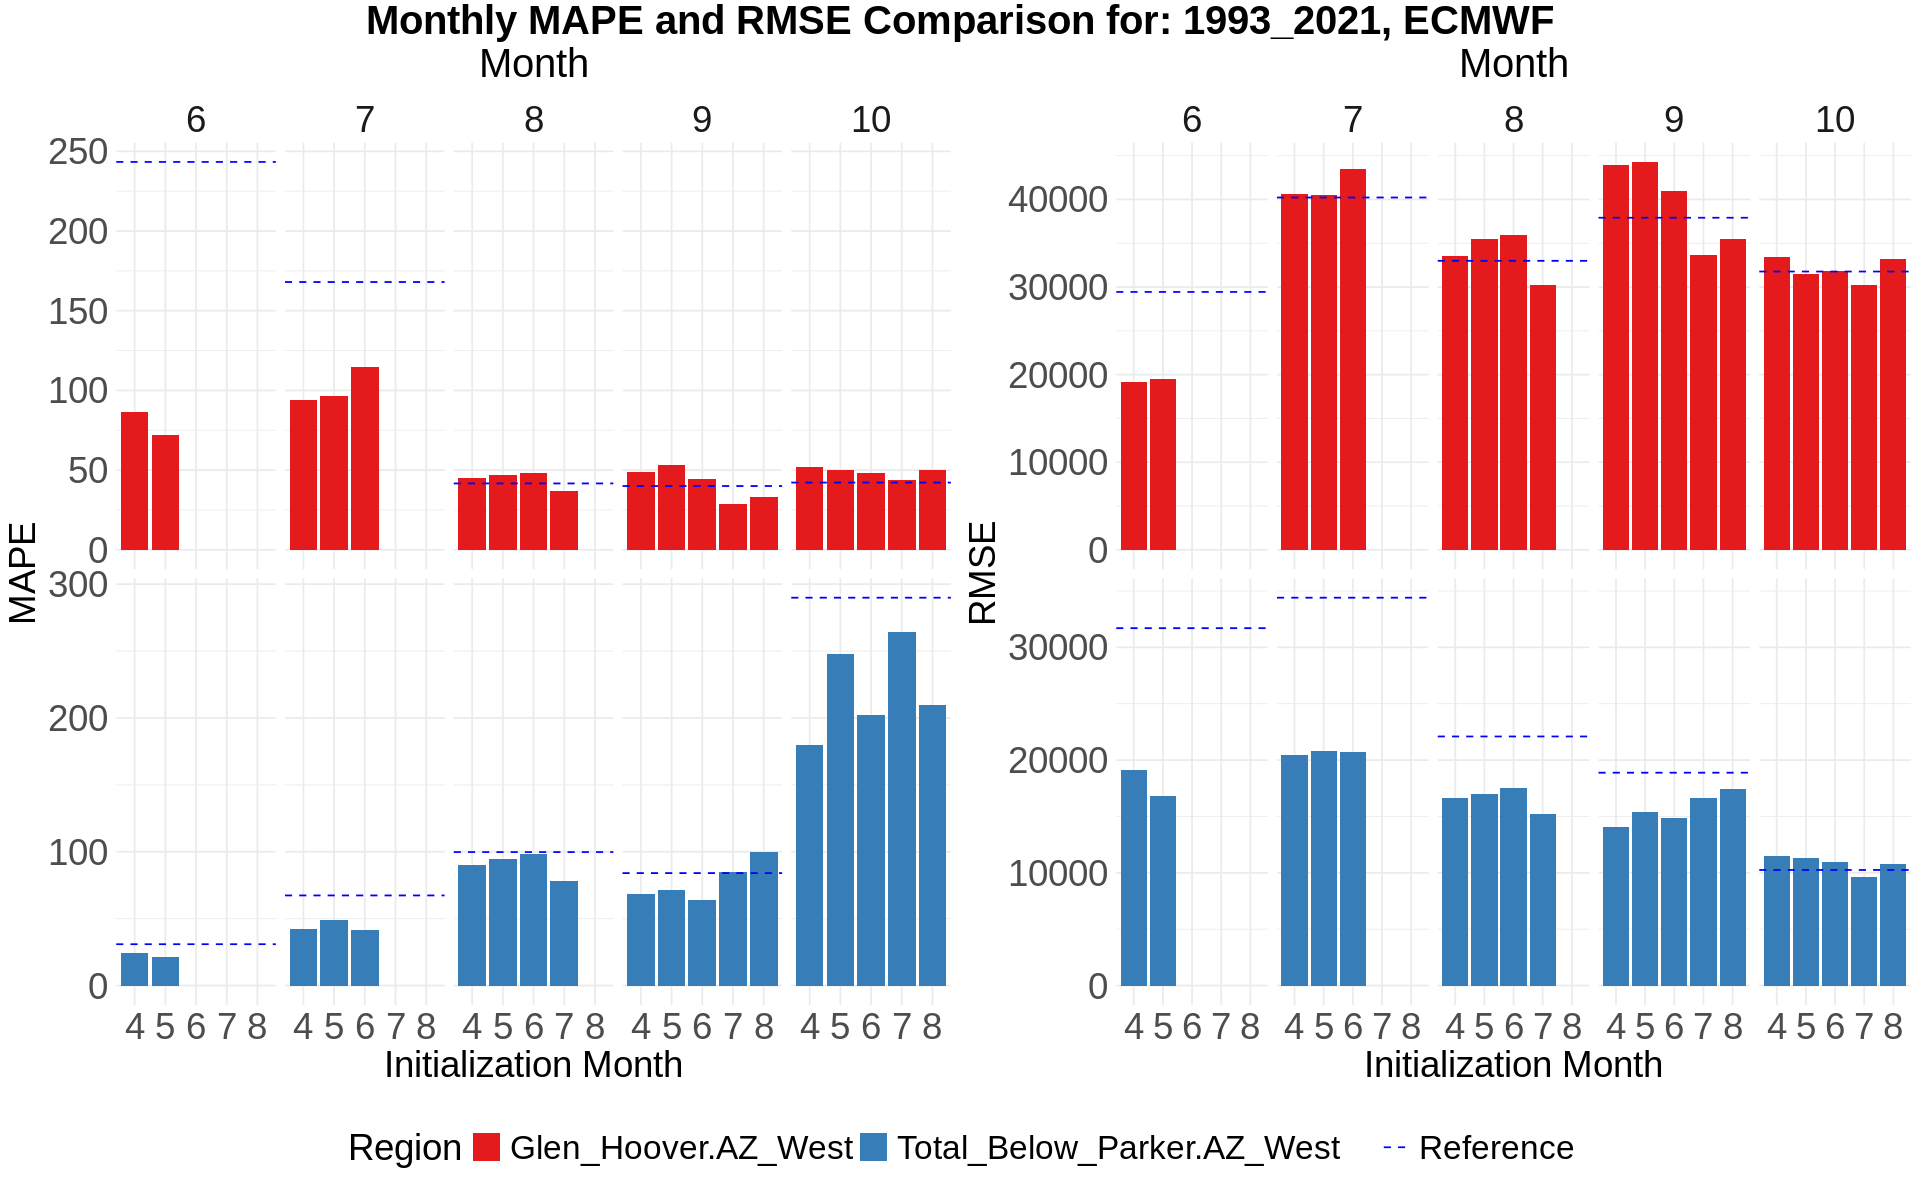

In [116]:
metrics <- c("MAE", "MAPE", "RMSE")
metrics <- c("MAPE", "RMSE")
plot_dir <- paste0("/content/",model_dir, "/plot_output/")

plot_list <- list()

for (metric in metrics) {
  metric_pred <- paste0("Monthly_", metric, "_pred")
  metric_ref <- paste0("Monthly_", metric, "_ref")

  options(repr.plot.width=16, repr.plot.height=10)

  p <- ggplot() +
    geom_bar(data = combined_metrics, aes(x = LeadMonth, y = .data[[metric_pred]], fill = Gage_Region),
             stat = "identity", position = position_dodge(width = 0.75), na.rm = TRUE) +
    geom_hline(data = combined_metrics %>% group_by(Gage_Region, Month) %>%
                 summarise(Avg_Ref = mean(.data[[metric_ref]], na.rm = TRUE), .groups = 'drop'),
               aes(yintercept = Avg_Ref, linetype = "Reference"), color = "blue", size = 0.5, na.rm = TRUE) +
    scale_linetype_manual(values = c(Reference = "dashed"), guide = guide_legend(title = "")) +
    facet_grid(Gage_Region ~ Month, scales = "free_y") +
    labs(title = "Month",
         x = "Initialization Month", y = metric, fill = "Region") +
    theme_minimal() +
    theme(plot.title = element_text(size = 24, hjust = 0.5),
          axis.title.x = element_text(size = 22),
          axis.title.y = element_text(size = 22),
          axis.text.x = element_text(size = 22),
          axis.text.y = element_text(size = 22),
          legend.title = element_text(size = 22),
          legend.text = element_text(size = 20),
          strip.text = element_text(size = 22)) +
    theme(axis.ticks.y.right = element_blank(),
          axis.text.y.right = element_blank()) +
    theme(legend.position = "bottom",
          legend.box = "horizontal",
          legend.box.just = "center",
          strip.text.y = element_blank()) +
    scale_fill_brewer(palette = "Set1")

  if (metric == "MAPE") {
    p <- p + scale_y_continuous(limits = c(0, NA), oob = scales::rescale_none)
#    p <- p + facet_grid(Gage_Region ~ Month, scales = "free_y", labeller = labeller(.rows = label_both)) +
#      geom_blank(data = combined_metrics %>% filter(Gage_Region == "Glen_Hoover.AZ_West"),
#                 aes(y = 250))  # Set y limit for Glen_Hoover.AZ_West in MAPE
#    p <- p + facet_grid(Gage_Region ~ Month, scales = "free_y", labeller = labeller(.rows = label_both)) +
#      geom_blank(data = combined_metrics %>% filter(Gage_Region == "Total_Below_Parker.AZ_West"),
#                 aes(y = 600))  # Set y limit for Total_Below_Parker.AZ_West in MAPE
  }

  if (metric == "RMSE") {
    p <- p + scale_y_continuous(limits = c(0, NA), oob = scales::rescale_none)
#    p <- p + facet_grid(Gage_Region ~ Month, scales = "free_y", labeller = labeller(.rows = label_both)) +
#      geom_blank(data = combined_metrics %>% filter(Gage_Region == "Glen_Hoover.AZ_West"),
#                 aes(y = 5000))  # Set y limit for Glen_Hoover.AZ_West in RMSE
#    p <- p + facet_grid(Gage_Region ~ Month, scales = "free_y", labeller = labeller(.rows = label_both)) +
#      geom_blank(data = combined_metrics %>% filter(Gage_Region == "Total_Below_Parker.AZ_West"),
#                 aes(y = 15000))  # Set y limit for Total_Below_Parker.AZ_West in RMSE
  }

  plot_list[[metric]] <- p
}

get_legend <- function(myplot) {
  tmp <- ggplot_gtable(ggplot_build(myplot))
  leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)
}

combined_plots <- lapply(plot_list, function(p) p + theme(legend.position = "none"))

legend <- get_legend(plot_list[[1]])

combined_plot <- arrangeGrob(
  grobs = c(combined_plots, list(legend)),
  layout_matrix = rbind(c(1, 2), c(3, 3)),
  heights = c(10, 1),
  top = textGrob(
    paste0("Monthly MAPE and RMSE Comparison for: ", year_start_metrics, "_", year_end_metrics, ", ", model_dir),
    gp = gpar(fontsize = 24, fontface = "bold")
  )
)

grid.newpage()
grid.draw(combined_plot)

# Save the combined plot
file_path <- paste0(plot_dir, "Metric_Comparison_Combined.png")
ggsave(file_path, plot = combined_plot, width = 40, height = 16, dpi = 300)


# Plot of the models metrics comparison
You should run the notebook for three time spans save the outputs in three folders for each model: \
SMYLE_Prein_data : Hindcast WT: 1982-2021 \
SMYLE_1985: Hindcast WT: 1985-2023 \
SMYLE_def: Hindcast WT: 1970-2023

ECMWF_Prein_data : Hindcast WT: 1982-2021 \
ECMWF_1985: Hindcast WT: 1985-2023 \
ECMWF_def: Hindcast WT: 1970-2023

In [117]:
# Load necessary libraries
library(ggplot2)
library(dplyr)
library(reshape2)
library(gridExtra)
library(grid)

path_prein <- '/content/SMYLE_Prein_data/12.combined_metrics.csv'
path_1985 <- '/content/SMYLE_1985/12.combined_metrics.csv'
path_def <- '/content/SMYLE_def/12.combined_metrics.csv'

data_prein <- read.csv(path_prein)
data_1985 <- read.csv(path_1985)
data_def <- read.csv(path_def)

data_prein$model <- 'Prein.et.al'
data_1985$model <- '1985_2023'
data_def$model <- '1970_2023'

combined_data <- bind_rows(data_prein, data_1985, data_def)

combined_data <- combined_data %>%
  mutate(
    RMSE = Monthly_RMSE_pred,
    MAPE = Monthly_MAPE_pred
  )

gage_regions <- unique(combined_data$Gage_Region)

plot_list <- list()
for (gage_region in gage_regions) {

  data_gage <- combined_data %>% filter(Gage_Region == gage_region)

  metrics <- c("RMSE", "MAPE")  # RMSE first, MAPE second

  for (metric in metrics) {

    p <- ggplot(data_gage) +
      geom_bar(aes(x = as.factor(LeadMonth), y = .data[[metric]], fill = model),
               stat = "identity", position = position_dodge(width = 0.75), na.rm = TRUE) +
      facet_grid(Gage_Region ~ Month, scales = "free_y") +
      labs(title = paste0(gage_region),
           x = "Lead Month", y = paste0(" ", metric), fill = "Search Pool Period") +
      theme_minimal() +
      theme(plot.title = element_text(size = 24, hjust = 0.5),
            axis.title.x = element_text(size = 22),
            axis.title.y = element_text(size = 22),
            axis.text.x = element_text(size = 16),
            axis.text.y = element_text(size = 16),
            legend.title = element_text(size = 18),
            legend.text = element_text(size = 16),
            strip.text = element_text(size = 18),
            axis.ticks.y.right = element_blank(),
            axis.text.y.right = element_blank(),
            legend.position = "bottom",
            legend.box = "horizontal",
            legend.box.just = "center",
            strip.text.y = element_blank()) +
      scale_fill_manual(values = c("Prein.et.al" = "black", "1985_2023" = "blue", "1970_2023" = "red"))

    plot_list[[paste0(gage_region, "_", metric)]] <- p
  }
}

get_legend <- function(myplot) {
  tmp <- ggplot_gtable(ggplot_build(myplot))
  leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)
}

combined_plots <- lapply(plot_list, function(p) p + theme(legend.position = "none"))
legend <- get_legend(plot_list[[1]])

combined_plot <- arrangeGrob(
  grobs = c(combined_plots[paste0(gage_regions[1], "_MAPE")], combined_plots[paste0(gage_regions[1], "_RMSE")],
            combined_plots[paste0(gage_regions[2], "_MAPE")], combined_plots[paste0(gage_regions[2], "_RMSE")], list(legend)),
  layout_matrix = rbind(c(1, 2), c(3, 4), c(5, 5)),
  heights = c(10, 10, 1),
  top = textGrob("Comparison of Prediction Errors by Search Pool Size, SMYLE", gp = gpar(fontsize = 24, fontface = "bold"))
)

grid.newpage()
grid.draw(combined_plot)

file_path <- "/content/Metric_Comparison_Combined.png"
ggsave(file_path, plot = combined_plot, width = 16, height = 20, dpi = 300)




Warning message in file(file, "rt"):
“cannot open file '/content/SMYLE_Prein_data/12.combined_metrics.csv': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection
